In [1]:
import numpy as np
import torch
import torchvision
import matplotlib.pyplot as plt
from time import time
from torchvision import datasets, transforms
from torch import nn, optim
import cv2
import os
import pandas as pd
import seaborn as sns
import random

In [2]:
#Read the images and the labels from the files
folders=['images/Source1/','images/Source2/','images/Source7/', 'chexpert/Train_reshape/', 'kaggle/Train/','IEEE8023/']
rd=pd.read_csv('Train_Combined.csv', index_col="Image Name")

X=[]
Y=[]
for folder in folders:
    print("Reading from ",folder)
    images=os.listdir(folder)
    if len(images)>200:
        images=random.sample(images,200)
    ctr=1
    for image in images:
        img=cv2.imread(folder+image)
        if img is not None and image in list(rd.index):
            img=cv2.resize(img, (32, 32), interpolation=cv2.INTER_AREA)           
            if folder!='chexpert/Train_reshape/':
                if rd.get_value(image,"Non-Pneumonia")==1:
                    X.append(img)
                    Y.append(1)
                if rd.get_value(image,"Other Pneumonia")==1:
                    X.append(img)
                    Y.append(2)
                if rd.get_value(image,"COVID-19")==1:
                    X.append(img)
                    Y.append(3)
            #Modify below to read label in excel
            else:
                if rd.get_value('Train_reshape/'+image,"Non-Pneumonia")==1:
                    X.append(img)
                    Y.append(1)
                if rd.get_value('Train_reshape/'+image,"Other Pneumonia")==1:
                    X.append(img)
                    Y.append(2)
                if rd.get_value('Train_reshape/'+image,"COVID-19")==1:
                    X.append(img)
                    Y.append(3)
            ctr+=1
        
covidtrainX= np.array(X)
covidtrainY=np.array(Y)
print("Shape of data:-")
print(covidtrainX.shape,covidtrainY.shape)

Reading from  images/Source1/


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:18: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:21: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:24: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead


Reading from  images/Source2/
Reading from  images/Source7/
Reading from  chexpert/Train_reshape/
Reading from  kaggle/Train/
Reading from  IEEE8023/
Shape of data:-
(477, 32, 32, 3) (477,)


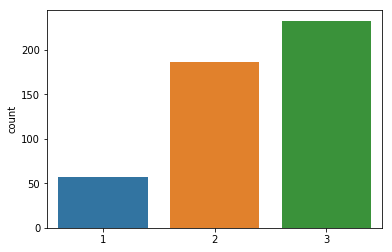

In [3]:
#Plot the count of different classes
sns.countplot(covidtrainY)

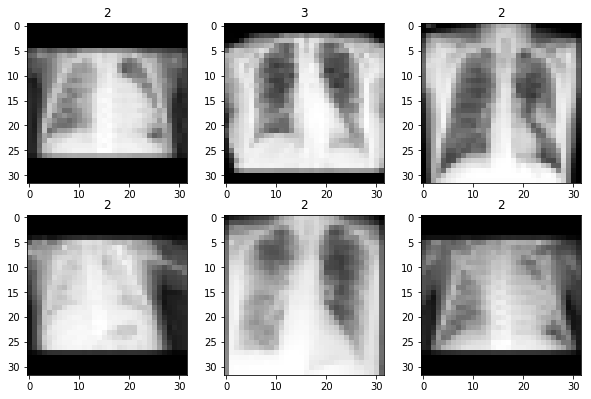

In [4]:
#show some imgaes and labels
plt.figure(figsize=(10, 10))
ctr=1
for i in random.sample(range(covidtrainX.shape[0]), 6): # how many imgs will show from the 3x3 grid
    plt.subplot(330 + ctr) # open next subplot
    plt.grid(False)
    plt.imshow(covidtrainX[i][:,:,0], cmap=plt.get_cmap('gray'))
    plt.title(covidtrainY[i])
    ctr+=1

In [5]:
train_ind=random.sample(range(covidtrainX.shape[0]), 400)
cros_val=[i for i in range(covidtrainX.shape[0]) if i not in train_ind]
covidtrainX=np.reshape(covidtrainX, (covidtrainX.shape[0],3072) )
X_train= covidtrainX[train_ind]
Y_train= covidtrainY[train_ind]
X_cv= covidtrainX[cros_val]
Y_cv= covidtrainY[cros_val]
print("X_train shape:",X_train.shape)
print("Y_train shape:",Y_train.shape)
Y_train=Y_train-1
Y_cv= Y_cv-1

X_train shape: (400, 3072)
Y_train shape: (400,)


In [104]:
# Following is the neural net architecture
input_size = 3072
hidden_sizes = [256,128]
output_size = 3

model = nn.Sequential(nn.Linear(input_size, hidden_sizes[0],bias=True),
                      nn.ReLU(),
                      nn.Linear(hidden_sizes[0], hidden_sizes[1],bias=True),
                      nn.ReLU(),
                      nn.Linear(hidden_sizes[1], output_size,bias=True),
                      nn.LogSoftmax(dim=1))

model=model.double()
print(model[0].weight)

Parameter containing:
tensor([[ 1.1090e-02,  1.5708e-02,  1.0456e-02,  ...,  1.4543e-02,
         -1.0764e-02, -6.7569e-03],
        [-7.4166e-03, -9.7267e-03,  2.7815e-05,  ..., -1.2620e-02,
         -1.2141e-02, -1.3408e-03],
        [-9.5816e-03,  1.7114e-02,  2.3235e-03,  ..., -5.9408e-03,
         -1.4264e-02,  1.1344e-02],
        ...,
        [-6.8865e-03,  1.6750e-03,  1.7091e-02,  ...,  1.2746e-02,
         -1.3959e-02, -1.0402e-02],
        [-5.2780e-03,  1.2195e-02,  1.2219e-02,  ..., -4.9759e-03,
          1.5576e-03, -1.0322e-02],
        [-9.9214e-03,  5.0464e-03,  8.4982e-03,  ...,  1.4564e-02,
         -1.2965e-02, -1.2898e-02]], dtype=torch.float64, requires_grad=True)


In [105]:
criterion = nn.NLLLoss(weight=torch.tensor(weights, dtype=torch.double))
images= torch.from_numpy(X_train[300]).double().reshape(3072,1)
images= (images-images.mean())/(max(images)-min(images))
# Training pass
optimizer.zero_grad()
output = model(images.T).requires_grad_(True)
labels=Y_train[300]
labels=labels.long()
labels=labels.reshape(1,)
print(output,labels)
loss = criterion(output, labels)     
print(loss)
#This is where the model learns by backpropagating   

print('Before backward pass grad: \n', model[0].weight.grad)
loss.backward() 

print('After backward pass grad: \n', model[0].weight.grad)

tensor([[-1.0653, -1.1445, -1.0876]], dtype=torch.float64,
       grad_fn=<LogSoftmaxBackward>) tensor([1])
tensor(1.1445, dtype=torch.float64, grad_fn=<NllLossBackward>)
Before backward pass grad: 
 None
After backward pass grad: 
 tensor([[-0.0000, -0.0000, -0.0000,  ..., -0.0000, -0.0000, -0.0000],
        [-0.0104, -0.0104, -0.0104,  ..., -0.0104, -0.0104, -0.0104],
        [ 0.0126,  0.0126,  0.0126,  ...,  0.0126,  0.0126,  0.0126],
        ...,
        [-0.0000, -0.0000, -0.0000,  ..., -0.0000, -0.0000, -0.0000],
        [-0.0005, -0.0005, -0.0005,  ..., -0.0005, -0.0005, -0.0005],
        [-0.0000, -0.0000, -0.0000,  ..., -0.0000, -0.0000, -0.0000]],
       dtype=torch.float64)


In [106]:
'''We now train the neural network and plot learning curves
Note:--The Class Imbalance is adjusted by attaching proper weights to the loss function'''
#import warnings; warnings.simplefilter('ignore')
Y_train = Y_train.float()
weights = [Y_train.shape[0]/sum([int(Y_train[j] == i) for j in range(Y_train.shape[0])]) for i in range(3)]
weights[2]/=10
criterion = nn.NLLLoss(weight=torch.tensor(weights, dtype=torch.double))
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
time0 = time()
epochs = 10
trainLoss=[]
cvLoss=[]

for e in range(epochs):
    print("Epoch:",e)
    running_loss = 0
    ctr=1
    for images, labels in zip(X_train,Y_train):
        # Flatten MNIST images into a 784 long vector
        images= torch.from_numpy(images).double().reshape(3072,1)
        images= (images-images.mean())/(max(images)-min(images))
        # Training pass
        optimizer.zero_grad()
        output = model(images.T).requires_grad_(True)
        labels=labels.long()
        labels=labels.reshape(1,)
        loss = criterion(output, labels)        
        #This is where the model learns by backpropagating     
        loss.backward()        
        #And optimizes its weights here
        optimizer.step()
        running_loss += loss.item()
        if pd.isnull(running_loss):
            print("Breaking at ",ctr)
            break
        ctr=ctr+1
    else:
        print("Epoch {} - Training loss: {}".format(e, running_loss/836))
        trainLoss.append(running_loss/836)
        c1=0
        c2=0
        for images, labels in zip(X_cv,Y_cv):
            c1=c1+1
            images= torch.from_numpy(X_train[2]).double().reshape(3072,1)
            images= (images-images.mean())/(max(images)-min(images))
            logsp = model(images.T)
            p_max, dig= logsp.max(1)
            if int(dig)==labels:
                c2=c2+1
        cvLoss.append(c2/c1)

print("\nTraining Time (in minutes) =",(time()-time0)/60)

Epoch: 0
Epoch 0 - Training loss: 0.3209716099631844
Epoch: 1
Epoch 1 - Training loss: 0.2410543000284244
Epoch: 2
Epoch 2 - Training loss: 0.2132305935532204
Epoch: 3
Epoch 3 - Training loss: 0.1922112781616053
Epoch: 4
Epoch 4 - Training loss: 0.17385057515027297
Epoch: 5
Epoch 5 - Training loss: 0.15748087691294596
Epoch: 6
Epoch 6 - Training loss: 0.14181994947772567
Epoch: 7
Epoch 7 - Training loss: 0.12634726626865164
Epoch: 8
Epoch 8 - Training loss: 0.11432038053614245
Epoch: 9
Epoch 9 - Training loss: 0.10123822083732494

Training Time (in minutes) = 11.697965741157532


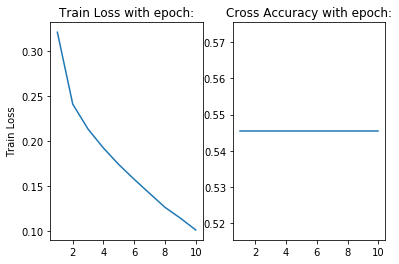

In [107]:
plt.subplot(1,2,1)
x=range(1, len(trainLoss)+1)
y=trainLoss
plt.plot(x,y)
plt.title("Train Loss with epoch:")
plt.ylabel("Train Loss")
plt.subplot(1,2,2)
plt.title("Cross Accuracy with epoch:")

x=range(1, len(cvLoss)+1)
y=cvLoss
plt.plot(x,y)

In [108]:
for image, label in zip(X_cv,Y_cv):
    images= torch.from_numpy(image).double().reshape(3072,1)
    images= (images-images.mean())/(max(images)-min(images))
    logsp = model(images.T)  
    ps = torch.exp(logsp)
    p_max, dig= ps.max(1)
    print("Predicted Digit =", int(dig), end=" ")
    print("label:",label) 

Predicted Digit = 2 label: 2
Predicted Digit = 2 label: 2
Predicted Digit = 2 label: 2
Predicted Digit = 2 label: 2
Predicted Digit = 2 label: 2
Predicted Digit = 2 label: 2
Predicted Digit = 2 label: 2
Predicted Digit = 2 label: 2
Predicted Digit = 2 label: 2
Predicted Digit = 2 label: 2
Predicted Digit = 2 label: 2
Predicted Digit = 2 label: 2
Predicted Digit = 2 label: 2
Predicted Digit = 2 label: 2
Predicted Digit = 2 label: 2
Predicted Digit = 2 label: 2
Predicted Digit = 2 label: 2
Predicted Digit = 2 label: 2
Predicted Digit = 2 label: 2
Predicted Digit = 2 label: 2
Predicted Digit = 2 label: 2
Predicted Digit = 2 label: 2
Predicted Digit = 2 label: 2
Predicted Digit = 2 label: 2
Predicted Digit = 2 label: 2
Predicted Digit = 2 label: 2
Predicted Digit = 2 label: 2
Predicted Digit = 2 label: 2
Predicted Digit = 1 label: 1
Predicted Digit = 2 label: 0
Predicted Digit = 1 label: 1
Predicted Digit = 1 label: 1
Predicted Digit = 1 label: 1
Predicted Digit = 1 label: 1
Predicted Digi

In [109]:
#Load Test data
#Read the images and the labels from the files
folders=['images/Source1/','images/Source2/','images/Source7/', 'chexpert/Train_reshape/', 'kaggle/Train/','IEEE8023/']
rd=pd.read_csv('Train_Combined.csv', index_col="Image Name")

X=[]
Y=[]
for folder in folders:
    print("Reading from ",folder)
    images=os.listdir(folder)
    if len(images)>20:
        images=random.sample(images,20)
    ctr=1
    for image in images:
        img=cv2.imread(folder+image)
        if img is not None and image in list(rd.index):
            img=cv2.resize(img, (32, 32), interpolation=cv2.INTER_AREA)           
            if folder!='chexpert/Train_reshape/':
                if rd.get_value(image,"Non-Pneumonia")==1:
                    X.append(img)
                    Y.append(1)
                if rd.get_value(image,"Other Pneumonia")==1:
                    X.append(img)
                    Y.append(2)
                if rd.get_value(image,"COVID-19")==1:
                    X.append(img)
                    Y.append(3)
            #Modify below to read label in excel
            else:
                if rd.get_value('Train_reshape/'+image,"Non-Pneumonia")==1:
                    X.append(img)
                    Y.append(1)
                if rd.get_value('Train_reshape/'+image,"Other Pneumonia")==1:
                    X.append(img)
                    Y.append(2)
                if rd.get_value('Train_reshape/'+image,"COVID-19")==1:
                    X.append(img)
                    Y.append(3)
            ctr+=1
        
covidtestX= np.array(X)
covidtestY=np.array(Y)
print("Shape of data:-")
print(covidtestX.shape,covidtestY.shape)


Reading from  images/Source1/


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:19: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:22: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:25: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead


Reading from  images/Source2/
Reading from  images/Source7/
Reading from  chexpert/Train_reshape/
Reading from  kaggle/Train/
Reading from  IEEE8023/
Shape of data:-
(68, 32, 32, 3) (68,)


In [111]:
covidtestX=np.reshape(covidtestX, (covidtestX.shape[0],3072))
c1=0
c2=0
for images, labels in zip(covidtestX,covidtestY):
    c1=c1+1
    images= torch.from_numpy(images).double().reshape(3072,1)
    images= (images-images.mean())/(max(images)-min(images))
    logsp = model(images.T)  
    p_max, dig= logsp.max(1)
    if int(dig)==labels:
        c2=c2+1
print("Test accuracy of the trained model is %f percent"%(c2/c1*100))

Test accuracy of the trained model is 14.705882 percent
